In [1]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2


from azure.quantum import Workspace 
from azure.quantum.qiskit import AzureQuantumProvider

import sys
import os

sys.path.append(os.path.abspath("..\\..\\.."))
from objects.FiveQbStabilizerCode import FiveQbStabilizerCodeCircuit
from functions import *


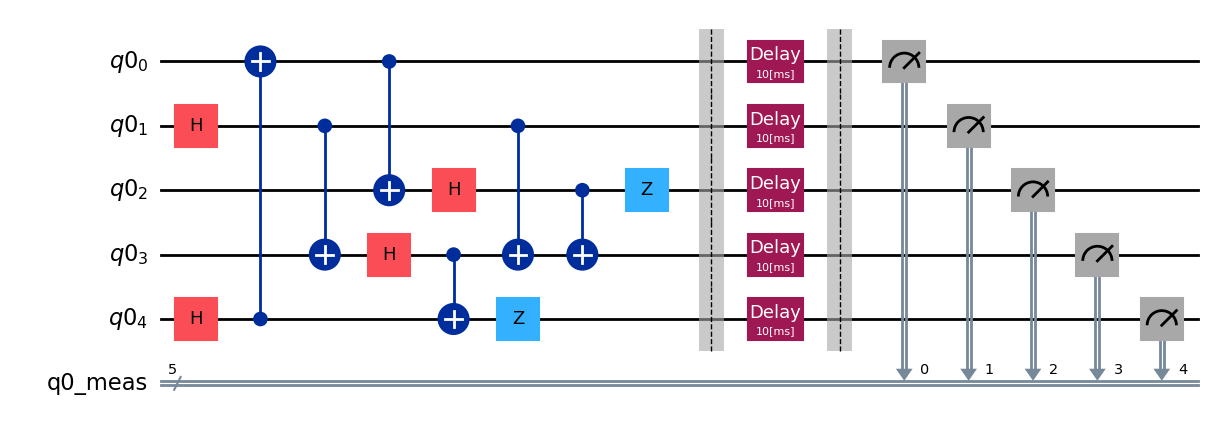

In [9]:


def load_circuit():
    qc = FiveQbStabilizerCodeCircuit(1)

    qc.encode(type='0')

    qc.delay(10, unit='ms')

    qc.measure_all()

    return qc

qc = load_circuit()
qc.draw('mpl')



In [10]:
# IonQ access
workspace = Workspace(  
    resource_id = "", # Add the resourceID of your workspace
    location = "" # Add the location of your workspace (for example "westus")
    )

provider = AzureQuantumProvider(workspace)

In [4]:
backend_name = "ionq.qpu.aria-1"
backend_name_simulator = "ionq.simulator"
backend = provider.get_backend(backend_name)
simulator_backend = provider.get_backend(backend_name_simulator)

option_params = {
    "error-mitigation": {
        "debias": False,
        "sharpen": False
    }
}

backend.options.update_options(**option_params)
simulator_backend.options.update_options(**option_params)
simulator_backend.options.update_options(noise_model="aria-1") 

Circuit Depth: 9


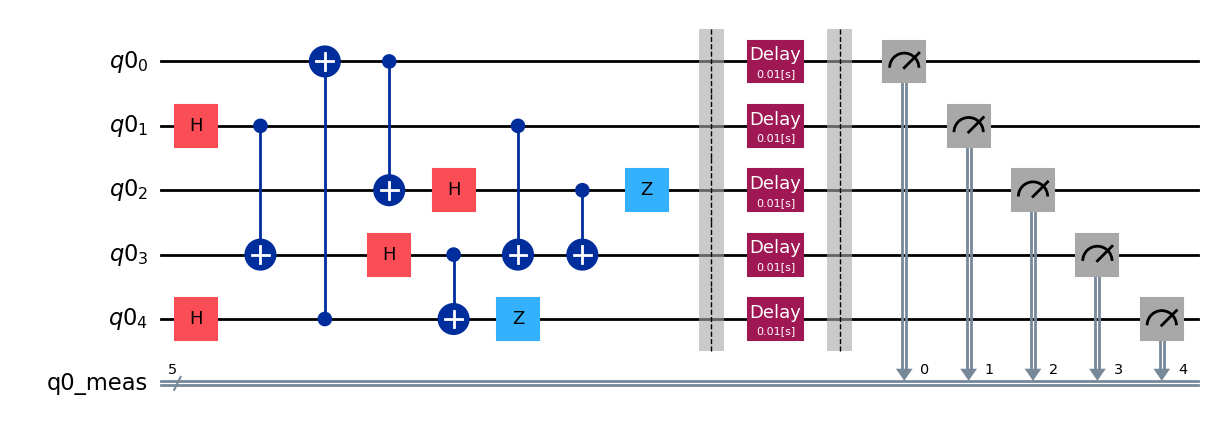

In [11]:

phy_qc = qc.physical_circuit
isa_circuit = transpile(phy_qc, backend, optimization_level=3)
print(f"Circuit Depth: {qc.physical_circuit.depth()}")
# print(f"Transpiled Circuit Depth: {isa_circuit.depth()}")
isa_circuit.draw(output='mpl')



In [12]:
circuits = [isa_circuit]

In [7]:
simulation_result = sampler_simulation(qc.physical_circuit, 3200)

for lq in qc.qubits:
    # state = lq.qb_measure
    state = lq.qb_measures
    # state = lq.all_measures
    print(f"  {state.name}: {simulation_result.data[state.name].get_counts()}")


  q0_meas: {'00101': 211, '11101': 210, '11110': 208, '01010': 178, '01001': 209, '10100': 203, '11011': 191, '10111': 174, '01100': 197, '11000': 204, '01111': 192, '00000': 189, '10010': 232, '00110': 207, '10001': 208, '00011': 187}


Run experiment

In [ ]:
shots = 3200
# job = backend.run(circuits, shots=shots)

# job_id = job.id()

# print(f"Job ID: {job_id}")


Job ID: 0aea7128-f9f5-11ef-a2fd-3800255d459d


In [20]:
results = extract_results_json_IONQ('5qb_stabilizer_T1_delay10ms.json', type='percentage', reverse_order=True)[0]
print(results)

{'00000': 6.502031884964052, '00001': 0.5939356048765239, '00010': 0.2188183807439825, '00011': 6.31447327289778, '00100': 0.1875586120662707, '00101': 5.032822757111598, '00110': 6.908408877774304, '00111': 0.4688965301656768, '01000': 0.2188183807439825, '01001': 6.908408877774304, '01010': 5.5329790559549865, '01011': 0.34385745545482965, '01100': 4.438887152235074, '01101': 0.28133791809940606, '01110': 0.2188183807439825, '01111': 6.502031884964052, '10000': 0.3751172241325414, '10001': 6.12691466083151, '10010': 5.189121600500156, '10011': 0.2188183807439825, '10100': 5.126602063144733, '10101': 0.3751172241325414, '10110': 0.15629884338855893, '10111': 6.970928415129728, '11000': 6.033135354798374, '11001': 0.40637699281025325, '11010': 0.28133791809940606, '11011': 4.626445764301344, '11100': 0.25007814942169426, '11101': 5.189121600500156, '11110': 7.4710847139731165, '11111': 0.5314160675211004}


In [21]:
states = [bin(i)[2:].zfill(5) for i in range(2**5)]
valid_states = [s for s in states if sum([int(i) for i in s]) % 2 == 0]

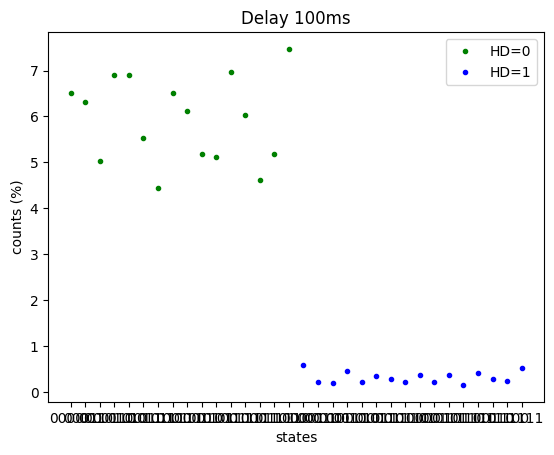

In [22]:
# results_no_delay = extract_results_json_IONQ('5qb_stabilizer_T1_all_meas.json', type='percentage', reverse_order=True)[0]
plot_results_hamming_distance(results, 5, valid_states, title='Delay 100ms')

In [23]:
print_order_results(results, valid_states=valid_states, limit=16)

state: result, HD, error positions
11110: 7.471%, 0, [[]]
10111: 6.971%, 0, [[]]
00110: 6.908%, 0, [[]]
01001: 6.908%, 0, [[]]
00000: 6.502%, 0, [[]]
01111: 6.502%, 0, [[]]
00011: 6.314%, 0, [[]]
10001: 6.127%, 0, [[]]
11000: 6.033%, 0, [[]]
01010: 5.533%, 0, [[]]
10010: 5.189%, 0, [[]]
11101: 5.189%, 0, [[]]
10100: 5.127%, 0, [[]]
00101: 5.033%, 0, [[]]
11011: 4.626%, 0, [[]]
01100: 4.439%, 0, [[]]


In [24]:
print('snr:', calculate_snr(results, valid_states))

snr: 18.506097560975608


TVD

In [27]:
tvd = calculate_tvd(results, generate_uniform_distribution(5, valid_states), percentage=True)

print("Total Variation Distance")
print(f"delay 10ms:\t{round(tvd*100,2)}%")

Total Variation Distance
delay 10ms:	8.95%


In [28]:
ks = calculate_test_ks(results, generate_uniform_distribution(5, valid_states), percentage=True)
print(f"test K-S: {round(ks*100,2)}%")

test K-S: 2.1%
